### Apply the model

##### libraries

In [1]:
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot
import plotly.express as px

In [2]:
df =pd.read_csv("aids_clean.csv")
df.head()

,time,trt,age,wtkg,hemo,drugs,karnof,oprior,z30,preanti,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,1108,1,37,88.11364,0,1,100,0,1,169,...,1,1,0,0,0,389,320,734,737,1
1,1079,0,43,66.77075,0,0,100,0,1,654,...,0,2,0,1,1,318,432,912,1213,0
2,492,1,34,82.91725,0,0,90,0,1,710,...,1,2,0,1,1,326,524,660,835,0
3,1191,1,41,98.91817,0,0,81,0,1,992,...,1,3,0,1,0,318,232,1131,982,1
4,1141,3,47,53.61717,0,0,100,0,0,0,...,0,1,0,1,0,280,337,515,679,0


#### K-fold cross validation to find the best hyperparameters
##### parameters are internal settings learned during training by the XGBoost algorithm itself, whereas hyperparameters are external settings that the user defines and adjusts to optimize the model's performance

In [3]:
import sklearn
import xgboost
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, confusion_matrix
from xgboost import XGBClassifier

X = df.drop('infected', axis=1)  
y = df['infected'].astype(int)  # Assicurati che y sia di tipo int (binario)
#X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

print(X.head())
print(round(len(y_train[y_train==1])/len(y_train),2))
print(round(len(y_test[y_test==1])/len(y_test),2))

print(len(y_train==0)/len(y_train[y_train==1]))

   time  trt  age      wtkg  hemo  drugs  karnof  oprior  z30  preanti  \
0  1108    1   37  88.11364     0      1     100       0    1      169   
1  1079    0   43  66.77075     0      0     100       0    1      654   
2   492    1   34  82.91725     0      0      90       0    1      710   
3  1191    1   41  98.91817     0      0      81       0    1      992   
4  1141    3   47  53.61717     0      0     100       0    0        0   

   gender  str2  strat  symptom  treat  offtrt  cd40  cd420  cd80  cd820  
0       0     1      1        0      0       0   389    320   734    737  
1       1     0      2        0      1       1   318    432   912   1213  
2       1     1      2        0      1       1   326    524   660    835  
3       1     1      3        0      1       0   318    232  1131    982  
4       1     0      1        0      1       0   280    337   515    679  
0.31
0.31
3.2287822878228782


#### Hyperparameters tuning

In [4]:
opt_parameters = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_lambda': [1, 5, 10],
    'reg_alpha': [1, 5, 10],
    'scale_pos_weight': [1, 1.5, 2, 2.5, 3, 3.22, 3.5, 4]
}

rand_search = RandomizedSearchCV(XGBClassifier(), param_distributions=opt_parameters, n_iter=30, scoring='recall', cv=10, verbose=0, random_state=96)
rand_search.fit(X_train, y_train)

best_params = rand_search.best_params_
print("Migliori Parametri:", best_params)

Migliori Parametri: {'subsample': 0.6, 'scale_pos_weight': 4, 'reg_lambda': 5, 'reg_alpha': 5, 'min_child_weight': 3, 'max_depth': 3, 'gamma': 0.3, 'colsample_bytree': 0.8}


#### The model

XGBoost model recall score: 0.8194


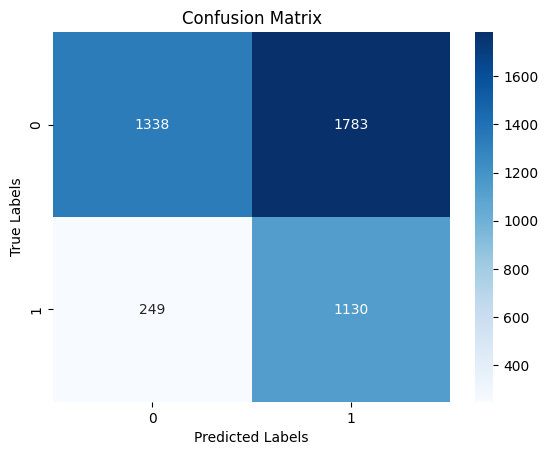

In [8]:
b_params = {
    'subsample': 0.6, 
    'scale_pos_weight': 4, 
    'reg_lambda': 5, 
    'reg_alpha': 5, 
    'min_child_weight': 1, 
    'max_depth': 3, 
    'gamma': 0.3, 
    'colsample_bytree': 0.8}

#fit the model on train set    
xgb_clf_best = XGBClassifier(**b_params)
xgb_clf_best.fit(X_train, y_train)

# Predictions on  test set
y_pred = xgb_clf_best.predict(X_test)

recall = recall_score(y_test, y_pred)
print('XGBoost model recall score: {0:0.4f}'.format(recall))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Be sure the model is not in overfitting

XGBoost model recall score on train set: 0.8835
XGBoost model recall score: 0.8194


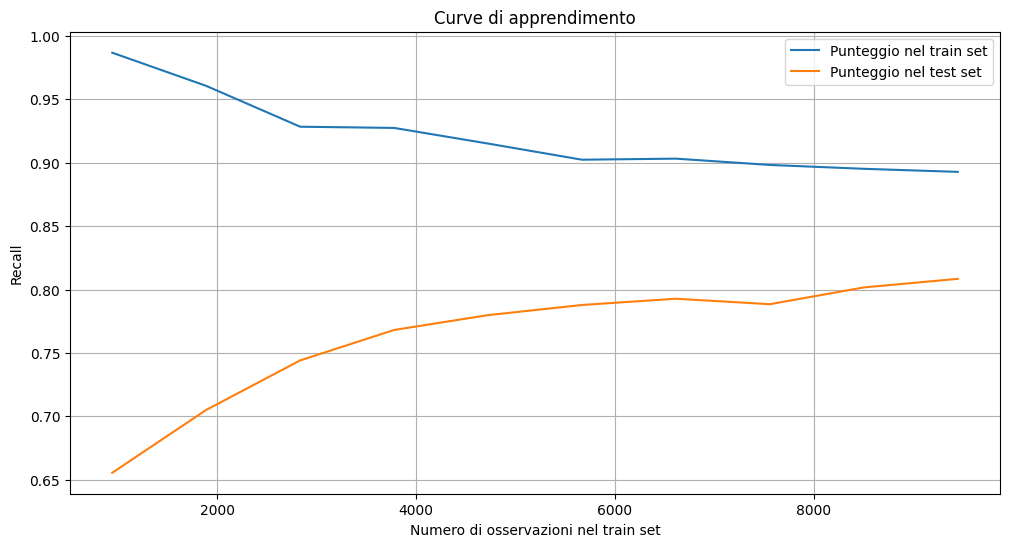

In [9]:
y_pred_train = xgb_clf_best.predict(X_train)
recall_train = recall_score(y_train, y_pred_train)
print('XGBoost model recall score on train set: {0:0.4f}'.format(recall_train))
print('XGBoost model recall score: {0:0.4f}'.format(recall))

from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, recall_score

# learning curve
def plot_learning_curve(estimator, X, y, cv=10, train_sizes=np.linspace(0.1, 1.0, 10)):
    recall_scorer = make_scorer(recall_score)
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=recall_scorer, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(train_sizes, train_scores_mean, label='Punteggio nel train set')
    plt.plot(train_sizes, validation_scores_mean, label='Punteggio nel test set')
    plt.ylabel('Recall')
    plt.xlabel('Numero di osservazioni nel train set')
    plt.title('Curve di apprendimento')
    plt.legend()
    plt.grid()
    plt.show()

# Tracciare le learning curve
plot_learning_curve(xgb_clf_best, X_train, y_train, cv=10)

